## Project Description:
In this project i want to implement a custom training loop for a deep learning model in TensorFlow and Keras in Eurosat Dataset. 

The training loop should perform the following tasks:

1. Load the training and validation data.
2. Define the model architecture using Keras.
3. Compile the model with a loss function and an optimizer.
4. Train the model for a specified number of epochs, using a batch size of your choice.
5. Evaluate the model on the validation data after each epoch.
6. Plot the training and validation loss and accuracy curves using matplotlib.

**constraints:**

* You must use the TensorFlow 2.x API.
* You must use the Keras API to define the model architecture.
* You must use a custom training loop, rather than the `fit` method provided by Keras.
* You must use a GPU, if available, for training the model.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
# for progress bar:
from tqdm import tqdm

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

## 1. Load the training and validation data
1.1. Use the TensorFlow Datasets to load the [Eurosat Dataset](https://www.tensorflow.org/datasets/catalog/eurosat).This dataset consist of satellite images from different types of zones\
You can check that this dataset has only one split `Train`. So create train/validation/test splits by using 70% of dataset as the train set, 15% for validation set and 15% for test set.

In [2]:
#get tensorflow dataset
dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='C:\\Users\\mbare\\tensorflow_datasets\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),

In [3]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [4]:
list(info.splits.keys())

['train']

In [5]:
# ! ls /root/tensorflow_datasets/eurosat/rgb/2.0.0

In [6]:
# Loading Data Set & Spliting it:
train, val, test = tfds.load(
    'eurosat/rgb',
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
)

In [7]:
datapoint = next(iter(train))
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

2.2 Inspect dataset: extract number of classes in the dataset, class names, number of data in the dataset and use the `tfds` visualization tool to visualize some of the data

In [ ]:
num_classes = info.features["label"].num_classes
print(f'Number of classes: {num_classes}')

print('-------------')

class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

Number of classes: 10
-------------


['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
num_examples = info.splits['train'].num_examples
print(f'Total number of data: {num_examples}')

Total number of data: 27000


In [10]:
# Train/Validation/Test Set Size:
train_size = int(0.7 * num_examples)
val_size = int(0.15 * num_examples)
test_size = num_examples - train_size - val_size
print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')
print(f'Test set size: {test_size}')

Training set size: 18900
Validation set size: 4050
Test set size: 4050


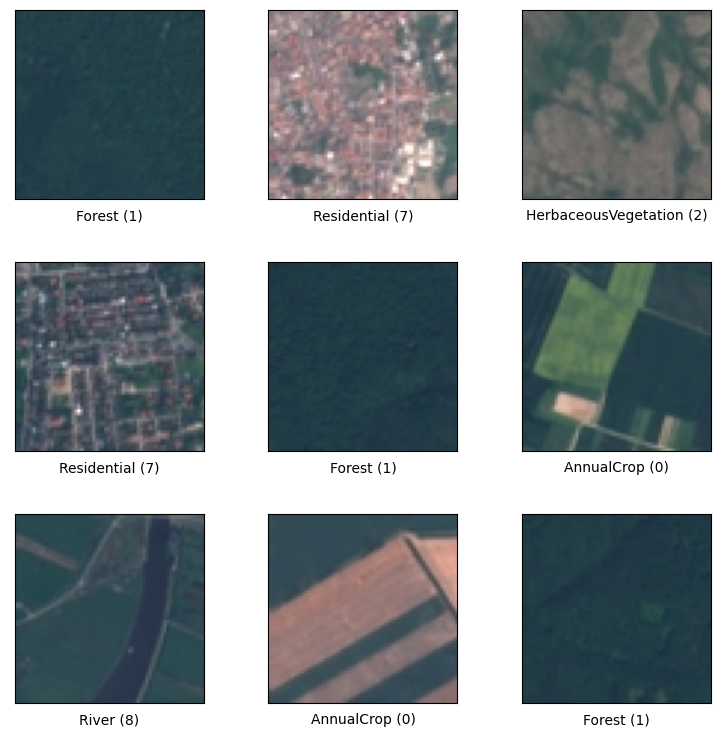

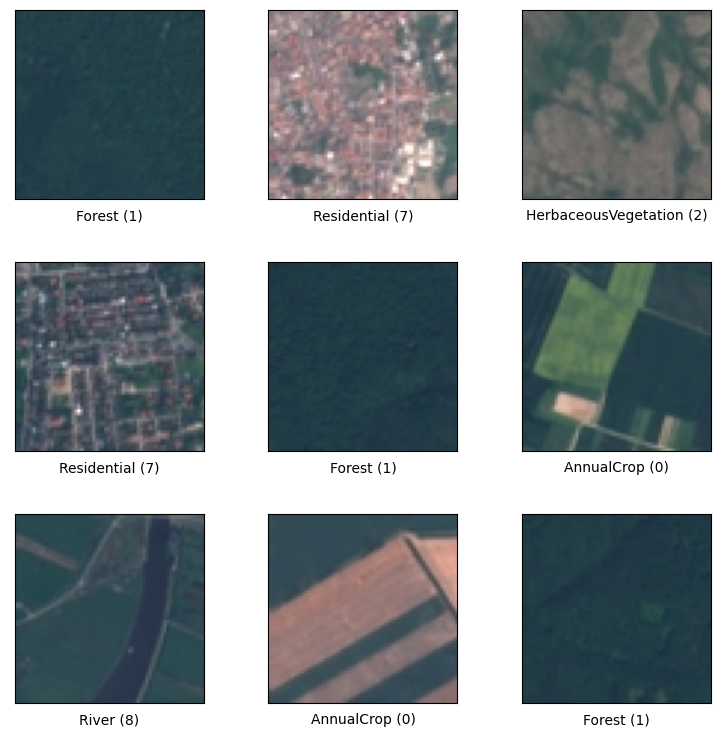

In [11]:
# استفاده از ابزار tfds برای نمایش داده‌ها
tfds.visualization.show_examples(train, info)

1.3. write a function that resize images to `64x64` and rescale the pixels to be between `[0,1]`. Also employ a one-hot encoding for the labels. Then by using `map` method apply this preprocessing function to all splits: (use num_parallel_calls argument in map function to run the function faster)

In [ ]:
# Pre-Processing Function
def preprocess(datapoint):
    image = datapoint['image']
    label = datapoint['label']

    # Resize the image to 64x64
    image = tf.image.resize(image, [64, 64])

    # Scale pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert the label to one-hot encoding
    label = tf.one_hot(label, num_classes)

    return image, label


# Apply the preprocess function to the datasets with parallel mapping
train = train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val = val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [13]:
# Verify that the pixels are in the [0, 1] range:
# Iterate through the dataset and convert each element to a NumPy array
pixel_values = []
for image, label in train:
    pixel_values.append(image.numpy())  # Extract the image tensor and convert it to a NumPy array

# Stack the NumPy arrays into a single array
pixel_values = np.stack(pixel_values)

# Calculate the minimum and maximum pixel values
print("Min and max pixel values:", pixel_values.min(), pixel_values.max())

Min and max pixel values: 0.0 1.0


In [14]:
pixel_values.shape

(18900, 64, 64, 3)

1.4. write several augmentation layer by your choice and apply it to training set

In [15]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.5272955>

In [ ]:
@tf.function
def augment(image, label):
    # Apply data augmentation techniques
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_saturation(image, lower=0.75, upper=1.5)
        image = tf.image.random_contrast(image, lower=0.75, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    # Apply random cropping
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_crop(image, size=[64, 64, 3])

    # Mask random regions of the image
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)  # Example transformation

    # Adjust JPEG quality randomly
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_jpeg_quality(
            image, min_jpeg_quality=70, max_jpeg_quality=100
        )

    return image, label


# Apply data augmentation to the training dataset
train_augmented = train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


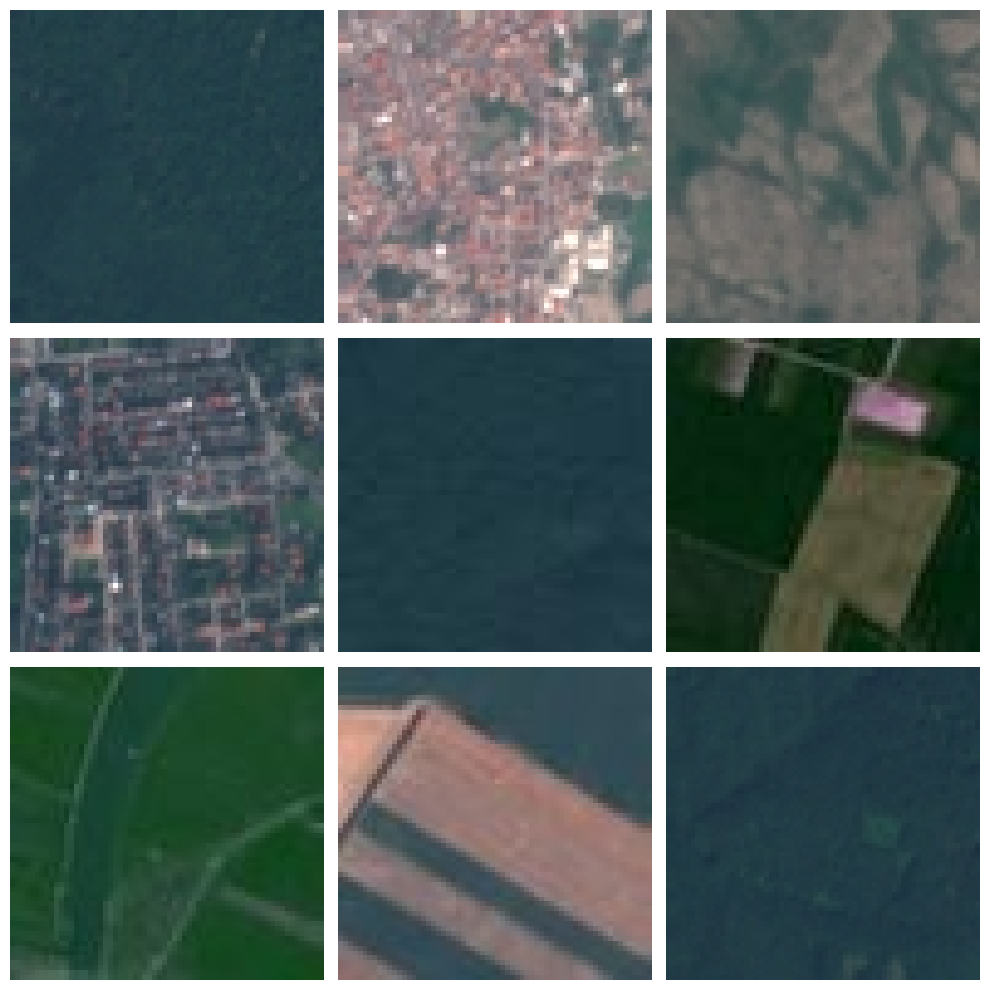

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display 9 image samples from train_augmented
plt.figure(figsize=(10, 10))

# Initialize row and column counters
row, col = 0, 0

# Iterate over 9 samples from the train_augmented dataset
for image, label in train_augmented.take(9):
    # Convert the tensor to a NumPy array
    image = image.numpy()

    # Clip pixel values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Display the image in a subplot
    plt.subplot(3, 3, row * 3 + col + 1)
    plt.imshow(image, vmin=0, vmax=1)  # Set the display range
    plt.axis('off')  # Hide the axes

    # Update counters for the next image
    col += 1
    if col == 3:
        row += 1
        col = 0

plt.tight_layout()
plt.show()


# A) First Approach with Repeat:

Tasks 1.5. & 1.6. both together:\
1.5. Shuffle training data and batch all splits \
1.6. Add cache and prefetch for optimizing the pipeline

In [ ]:
# Define batch size and buffer size
batch_size = 16
buffer_size = 1000

# Shuffle, cache, batch, repeat, and prefetch for the training dataset
train_dataset = (
    train_augmented.cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# Cache, batch, and prefetch for the validation dataset
validation_dataset = (
    val.cache()
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# Cache, batch, and prefetch for the test dataset
test_dataset = (
    test.cache()
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


## 2. Define the model architecture
implement following model with functional API:
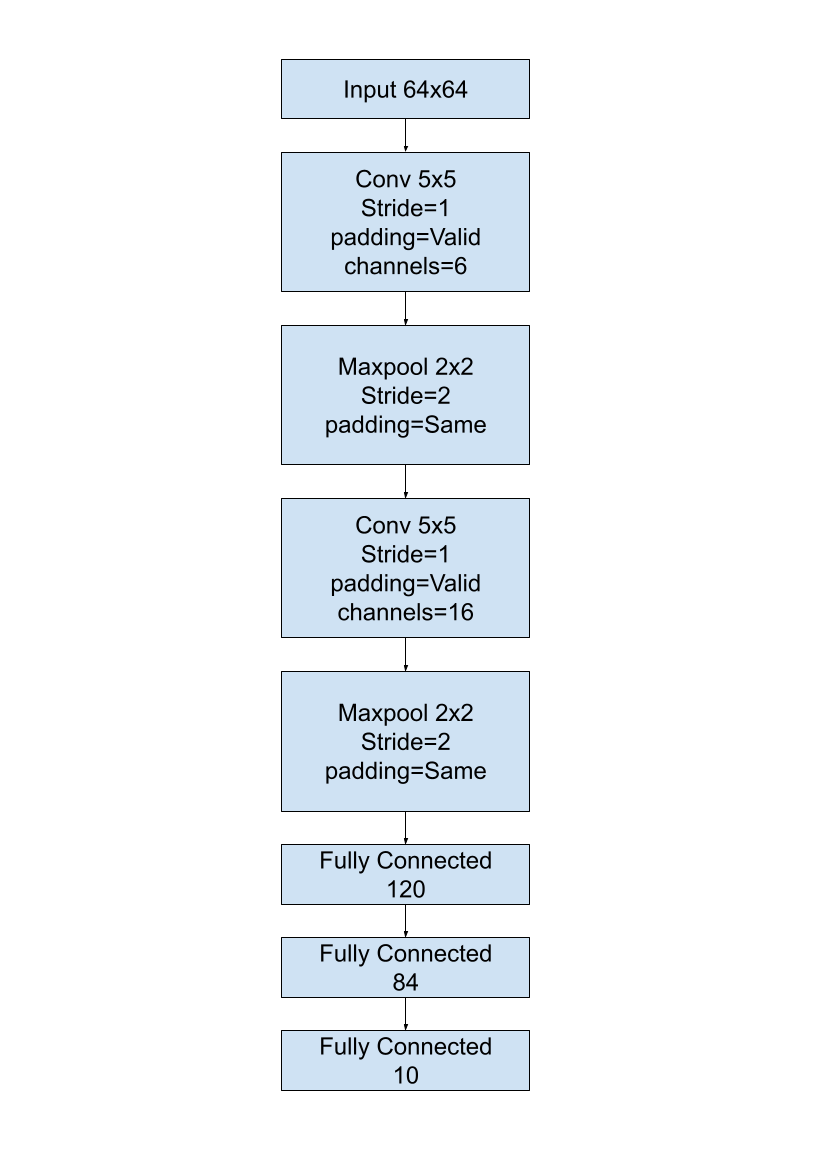

In [ ]:
def create_model():
    # Input layer
    inputs = tf.keras.Input(shape=(64, 64, 3))

    # Convolutional and Max-Pooling layers
    x = tf.keras.layers.Conv2D(6, kernel_size=5, activation='relu', padding='valid', strides=1)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    x = tf.keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='valid', strides=1)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Flatten or Global Average Pooling
    x = tf.keras.layers.Flatten()(x)  # Alternatively: tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = tf.keras.layers.Dense(120, activation='relu')(x)
    x = tf.keras.layers.Dense(84, activation='relu')(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Instantiate the model
model = create_model()

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2704)              0     

## 3. Define the Loss Function, Optimizer and Metrics
define a categorical cross-entropy loss, an Adam optimizer and accuracy metric for training and validation.

In [20]:
for x_batch_train, y_batch_train in train_dataset.take(1):
    print(f'Shape of labels: {y_batch_train.shape}')
    print(f'Data type of labels: {y_batch_train.dtype}')
    print(f'Example of labels: {y_batch_train.numpy()}')


Shape of labels: (16, 10)
Data type of labels: <dtype: 'float32'>
Example of labels: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
# Define the loss function (Categorical Crossentropy)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Define the optimizer (Adam Optimization: a stochastic gradient descent method)

# First learning rate attempt (did not yield good results)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Second approach (caused overfitting and was discarded)
# initial_learning_rate = 1e-4
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.9,
#     staircase=True
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Optimized approach with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Define the evaluation metrics (Categorical Accuracy)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
val_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')


## 4. Training Loop
Write a custom training and evaluation loop and store training and validation loss and training and validation accuracy of each epoch in a list:\
# Define the number of epochs and the batch size
num_epochs = 10\
train_losses = []\
train_accuracies = []\
val_losses = []\
val_accuracies = []
# Iterate over the number of epochs
for epoch in range(num_epochs):\
    #Code Here

In [22]:
def perform_validation():
    losses = []
    for x_val, y_val in validation_dataset:
        val_logits = model(x_val, training=False)  # اعتبارسنجی: training=False
        val_loss = loss_fn(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

In [ ]:
import os

# Get the current working directory where the notebook is being executed
current_dir = os.getcwd()

# Define the path for saving the best model
checkpoint_path = os.path.join(current_dir, "best_model.h5")


In [25]:
num_train_samples = len(train)
num_train_samples

18900

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Number of training samples (replace with the actual value)
num_train_samples = len(train)

# Hyperparameters
batch_size = 16
buffer_size = 1000

# Compute steps per epoch considering the dataset is repeated indefinitely
steps_per_epoch = num_train_samples // batch_size

# Variables to track the best model and losses
best_val_loss = np.inf  # Initial value for best validation loss
current_dir = os.getcwd()
checkpoint_path = os.path.join(current_dir, "best_model.h5")  # Path to save the best model

# Number of training epochs
epochs = 10

# Lists to store metrics for each epoch
epochs_val_losses, epochs_train_losses = [], []
epochs_train_accuracies, epochs_val_accuracies = [], []

for epoch in range(epochs):
    print(f'Start of epoch {epoch}')

    # Initialize list to store training losses for this epoch
    losses = []

    # Progress bar for tracking steps
    pbar = tqdm(total=steps_per_epoch, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    # Training loop
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Record gradients for backpropagation
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)  # Forward pass
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)  # Compute loss

        # Compute gradients and update weights
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Track the loss and accuracy for this batch
        losses.append(loss_value)
        train_acc_metric(y_batch_train, logits)  # Update training accuracy metric

        # Update the progress bar
        pbar.set_description(f"Training loss for step {int(step)}: {float(loss_value):.4f}")
        pbar.update()

        # Stop the loop after reaching the required number of steps
        if step >= steps_per_epoch - 1:
            break

    pbar.close()

    # Calculate metrics at the end of the epoch
    train_acc = train_acc_metric.result().numpy()
    losses_val = perform_validation()  # Function to compute validation losses
    val_acc = val_acc_metric.result().numpy()

    # Compute mean losses for the epoch
    losses_train_mean = np.mean(losses)
    losses_val_mean = np.mean(losses_val)

    # Store metrics for later analysis
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)
    epochs_train_accuracies.append(train_acc)
    epochs_val_accuracies.append(val_acc)

    # Print metrics for the epoch
    print(f'\n Epoch {epoch}: Train loss: {losses_train_mean:.4f}, Validation Loss: {losses_val_mean:.4f}, '
          f'Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Save the best model if validation loss improves
    if losses_val_mean < best_val_loss:
        best_val_loss = losses_val_mean
        model.save(checkpoint_path)
        print(f'Best model saved at epoch {epoch} with validation loss: {best_val_loss:.4f}')

    # Reset the metrics for the next epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()


Start of epoch 0


Training loss for step 1180: 1.4060: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 0: Train loss: 1.7475  Validation Loss: 1.2934, Train Accuracy: 0.3467, Validation Accuracy 0.5721


Best model saved at epoch 0 with validation loss: 1.2934
Start of epoch 1


Training loss for step 1180: 1.2544: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 1: Train loss: 1.3340  Validation Loss: 1.1203, Train Accuracy: 0.5079, Validation Accuracy 0.6128


Best model saved at epoch 1 with validation loss: 1.1203
Start of epoch 2


Training loss for step 1180: 1.3390: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 2: Train loss: 1.1932  Validation Loss: 1.0934, Train Accuracy: 0.5666, Validation Accuracy 0.6304


Best model saved at epoch 2 with validation loss: 1.0934
Start of epoch 3


Training loss for step 1180: 1.0405: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 3: Train loss: 1.1005  Validation Loss: 0.9261, Train Accuracy: 0.6017, Validation Accuracy 0.6719


Best model saved at epoch 3 with validation loss: 0.9261
Start of epoch 4


Training loss for step 1180: 1.2639: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 4: Train loss: 1.0427  Validation Loss: 1.0423, Train Accuracy: 0.6214, Validation Accuracy 0.6304
Start of epoch 5


Training loss for step 1180: 0.6122: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 5: Train loss: 1.0121  Validation Loss: 0.8781, Train Accuracy: 0.6309, Validation Accuracy 0.6921


Best model saved at epoch 5 with validation loss: 0.8781
Start of epoch 6


Training loss for step 1180: 1.0556: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 6: Train loss: 0.9821  Validation Loss: 0.8479, Train Accuracy: 0.6433, Validation Accuracy 0.6995


Best model saved at epoch 6 with validation loss: 0.8479
Start of epoch 7


Training loss for step 1180: 0.9429: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 7: Train loss: 0.9576  Validation Loss: 0.8857, Train Accuracy: 0.6526, Validation Accuracy 0.6719
Start of epoch 8


Training loss for step 1180: 0.6111: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 8: Train loss: 0.9371  Validation Loss: 0.8206, Train Accuracy: 0.6584, Validation Accuracy 0.7037


Best model saved at epoch 8 with validation loss: 0.8206
Start of epoch 9


Training loss for step 1180: 1.1571: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 9: Train loss: 0.9278  Validation Loss: 0.9031, Train Accuracy: 0.6605, Validation Accuracy 0.6835


## 5. Plot the training and validation loss and accuracy curves using matplotlib.
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):\
     #Code Here


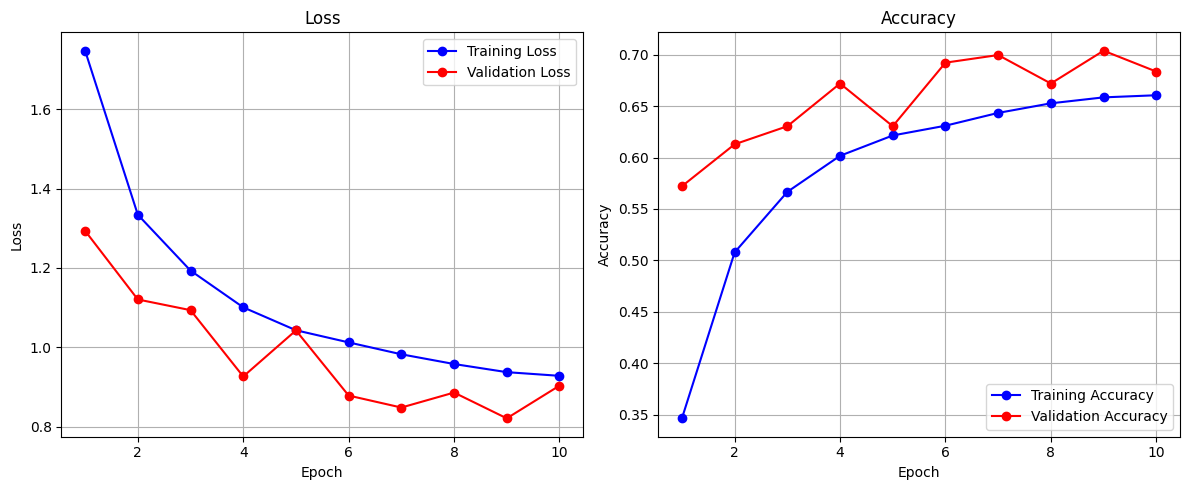

In [ ]:
# Plotting Loss and Accuracy Curves
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')  # Blue line for training loss
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')  # Red line for validation loss
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')  # Blue line for training accuracy
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')  # Red line for validation accuracy
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout for better display
    plt.show()

# Calling the function to plot the curves
plot_loss_and_accuracy(epochs_train_losses, epochs_val_losses, epochs_train_accuracies, epochs_val_accuracies)


<div style="font-family: 'Nazanin', serif;">
    <h1 style="font-family: 'Nazanin', sans-serif; font-weight: bold; font-size: 24px;">Model Result Analysis</h1>
        <p style="font-size: 16px;">
            1- Train Loss: With the reduction in the learning rate, the Train Loss has increased to a higher value than before. This indicates that the model has not fully adapted to the training data.
        </p>
        <p style="font-size: 16px;">
            2- Validation Loss: The decrease in Validation Loss shows that the model has improved and is better at generalizing to new data.
        </p>
        <p style="font-size: 16px;">
            3- Validation Accuracy: The increase in Validation Accuracy indicates that the model is performing better and making more accurate predictions.
        </p>
    <h1 style="font-family: 'Nazanin', sans-serif; font-weight: bold; font-size: 24px;">Suggestions for Further Improvement:</h1>
        <p style="font-size: 16px;">
            Testing the model with a larger number of epochs could help in better evaluating the model. Therefore, it is recommended to try more epochs so the model can stabilize further and show more improvements.
        </p>
</div>


In [ ]:
# Second Code Training Loop Version: after using repeat in train_dataset shuffle & cache & prefetch
# Increasing the number of epochs for optimizing model results:

# Number of training data samples (we replaced with the actual value)
num_train_samples = len(train) 
batch_size = 16
buffer_size = 1000

# Calculate the number of steps per epoch
# because of using repeat:
steps_per_epoch = num_train_samples // batch_size

best_val_loss = np.inf  # Initial value for best validation loss
current_dir = os.getcwd()
checkpoint_path = os.path.join(current_dir, "best_model2.h5")  # Path to save the model

epochs = 16
epochs_val_losses, epochs_train_losses = [], []
epochs_train_accuracies, epochs_val_accuracies = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    losses = []

    pbar = tqdm(total=steps_per_epoch, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        losses.append(loss_value)
        train_acc_metric(y_batch_train, logits)

        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()

        # Break the loop if the desired number of steps is reached
        if step >= steps_per_epoch - 1:
            break

    pbar.close()

    train_acc = train_acc_metric.result().numpy()
    losses_val = perform_validation()
    val_acc = val_acc_metric.result().numpy()

    losses_train_mean = np.mean(losses)
    losses_val_mean = np.mean(losses_val)
    
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)
    epochs_train_accuracies.append(train_acc)
    epochs_val_accuracies.append(val_acc)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % 
          (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

    # Save the best model based on validation loss
    if losses_val_mean < best_val_loss:
        best_val_loss = losses_val_mean
        model.save(checkpoint_path)
        print(f'Best model saved at epoch {epoch} with validation loss: {best_val_loss:.4f}')

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()


Start of epoch 0


Training loss for step 1180: 0.8180: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 0: Train loss: 0.9017  Validation Loss: 0.8720, Train Accuracy: 0.6732, Validation Accuracy 0.6800


Best model saved at epoch 0 with validation loss: 0.8720
Start of epoch 1


Training loss for step 1180: 1.2950: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 1: Train loss: 0.8881  Validation Loss: 0.8521, Train Accuracy: 0.6750, Validation Accuracy 0.6958


Best model saved at epoch 1 with validation loss: 0.8521
Start of epoch 2


Training loss for step 1180: 0.6098: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 2: Train loss: 0.8711  Validation Loss: 0.8350, Train Accuracy: 0.6804, Validation Accuracy 0.6867


Best model saved at epoch 2 with validation loss: 0.8350
Start of epoch 3


Training loss for step 1180: 1.0137: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 3: Train loss: 0.8600  Validation Loss: 0.9240, Train Accuracy: 0.6898, Validation Accuracy 0.6462
Start of epoch 4


Training loss for step 1180: 0.7909: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 4: Train loss: 0.8462  Validation Loss: 0.7890, Train Accuracy: 0.6945, Validation Accuracy 0.7185


Best model saved at epoch 4 with validation loss: 0.7890
Start of epoch 5


Training loss for step 1180: 0.8253: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 5: Train loss: 0.8225  Validation Loss: 0.8041, Train Accuracy: 0.7006, Validation Accuracy 0.7160
Start of epoch 6


Training loss for step 1180: 0.7607: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 6: Train loss: 0.8168  Validation Loss: 0.7656, Train Accuracy: 0.7043, Validation Accuracy 0.7259


Best model saved at epoch 6 with validation loss: 0.7656
Start of epoch 7


Training loss for step 1180: 0.9431: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 7: Train loss: 0.7994  Validation Loss: 0.7999, Train Accuracy: 0.7106, Validation Accuracy 0.7106
Start of epoch 8


Training loss for step 1180: 0.4714: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 8: Train loss: 0.7815  Validation Loss: 0.7580, Train Accuracy: 0.7155, Validation Accuracy 0.7328


Best model saved at epoch 8 with validation loss: 0.7580
Start of epoch 9


Training loss for step 1180: 0.7928: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 9: Train loss: 0.7643  Validation Loss: 0.8053, Train Accuracy: 0.7257, Validation Accuracy 0.6993
Start of epoch 10


Training loss for step 1180: 0.8640: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 10: Train loss: 0.7505  Validation Loss: 0.8022, Train Accuracy: 0.7268, Validation Accuracy 0.6995
Start of epoch 11


Training loss for step 1180: 0.4583: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 11: Train loss: 0.7351  Validation Loss: 0.7584, Train Accuracy: 0.7335, Validation Accuracy 0.7237
Start of epoch 12


Training loss for step 1180: 0.7439: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 12: Train loss: 0.7197  Validation Loss: 0.7276, Train Accuracy: 0.7408, Validation Accuracy 0.7407


Best model saved at epoch 12 with validation loss: 0.7276
Start of epoch 13


Training loss for step 1180: 0.9629: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 13: Train loss: 0.7097  Validation Loss: 0.7565, Train Accuracy: 0.7457, Validation Accuracy 0.7299
Start of epoch 14


Training loss for step 1180: 0.4042: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 14: Train loss: 0.6946  Validation Loss: 0.7333, Train Accuracy: 0.7492, Validation Accuracy 0.7336
Start of epoch 15


Training loss for step 1180: 0.4949: 100%|█████████████████████████████████████████████████████████████████| 1181/1181 



 Epoch 15: Train loss: 0.6813  Validation Loss: 0.7611, Train Accuracy: 0.7539, Validation Accuracy 0.7284


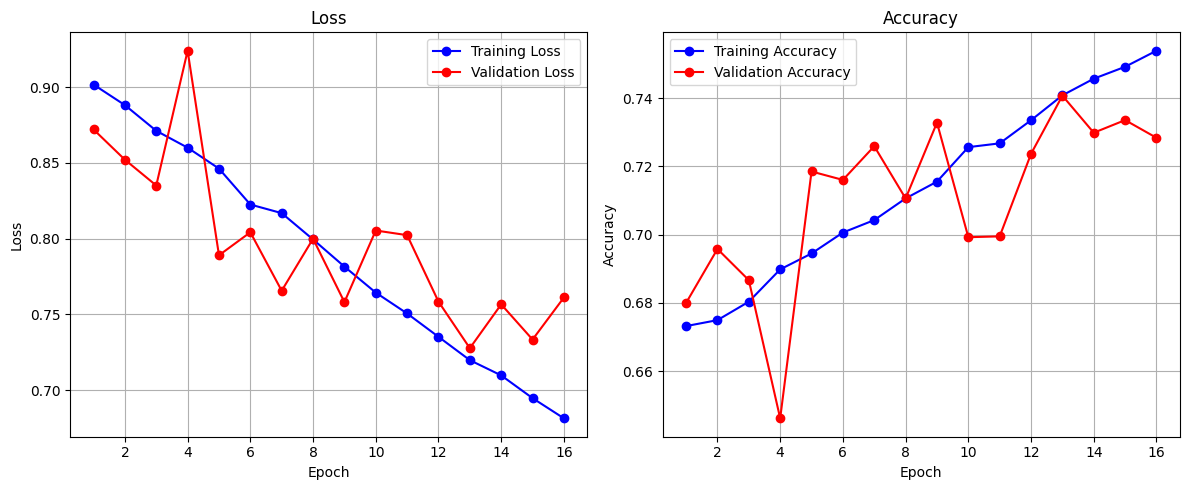

In [ ]:
# Plotting Loss and Accuracy Curves
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting the loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting the accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Calling the function to plot the curves
plot_loss_and_accuracy(epochs_train_losses, epochs_val_losses, epochs_train_accuracies, epochs_val_accuracies)


This function displays a row of images with their predictions and true labels.

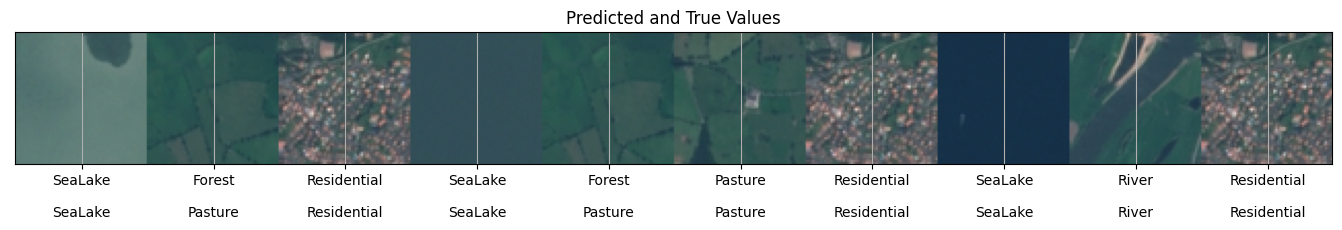

In [ ]:
# Fixing the image display function
def display_images(images, predictions, labels, title, n):
    # Create strings combining predicted and actual labels
    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    plt.figure(figsize=(17, 3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([64*x+32 for x in range(n)], display_strings)
    plt.grid(None)
    
    # Assuming the images are 64x64, no need to change dimensions
    image = np.reshape(images, [n, 64, 64, 3])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [64, 64*n, 3])
    plt.imshow(image)

# Getting test inputs
test_inputs = test_dataset.take(1)
x_batches, y_pred_batches, y_true_batches = [], [], []

# Collecting the predictions and true labels
for x, y in test_inputs:
    y_pred = model(x)
    y_pred_batches.extend(y_pred.numpy())
    y_true_batches.extend(y.numpy())
    x_batches.extend(x.numpy())

# Randomly selecting 10 samples for display
indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = np.array(x_batches)[indexes]
y_pred_to_plot = np.array(y_pred_batches)[indexes]
y_true_to_plot = np.array(y_true_batches)[indexes]

# Converting predictions and true values to class names
y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[np.argmax(sel_y_true)] for sel_y_true in y_true_to_plot]

# Displaying images with predicted and true labels
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)


# B) Second Approach without Repeat:

In [ ]:
batch_size = 16
buffer_size = 1000

# Shuffle, cache, batch, repeat, prefetch training data
train_dataset2 = train_augmented.cache() \
                               .shuffle(buffer_size) \
                               .batch(batch_size) \
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Cache and batch validation data
validation_dataset = val.cache() \
                        .batch(batch_size) \
                        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Cache and batch test data
test_dataset = test.cache() \
                   .batch(batch_size) \
                   .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [32]:
model2 = create_model()
for x_batch_train, y_batch_train in train_dataset2.take(1):
    print(f'Shape of labels: {y_batch_train.shape}')
    print(f'Data type of labels: {y_batch_train.dtype}')
    print(f'Example of labels: {y_batch_train.numpy()}')

Shape of labels: (16, 10)
Data type of labels: <dtype: 'float32'>
Example of labels: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Define loss function (Categorical Crossentropy)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Define optimizer (Adam Optimizer: Adam optimization is a stochastic gradient descent method)
# Adjusting to a lower learning rate for a more optimal approach
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  

# Define evaluation metrics (Categorical Accuracy)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='train_acc_metric')
val_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='val_acc_metric')


In [ ]:
def perform_validation():
    losses = []
    for x_val, y_val in validation_dataset:
        val_logits = model2(x_val, training=False)  # validation: training=False
        val_loss = loss_fn(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

In [ ]:
# Third Code Training Loop Version: If we didn't use repeat in shuffle & cache & prefetch train_dataset 
# This code is kept only for archiving in the notebook and was not used in this version.

best_val_loss = np.inf  # Initial value for the best validation loss
current_dir = os.getcwd()
checkpoint_path = os.path.join(current_dir, "best_model3.h5")  # Path to save the model

epochs = 10
epochs_val_losses, epochs_train_losses = [], []
epochs_train_accuracies, epochs_val_accuracies = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    losses = []

    pbar = tqdm(total=len(train_dataset2), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset2):
        with tf.GradientTape() as tape:
            logits = model2(x_batch_train, training=True)
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)
        gradients = tape.gradient(loss_value, model2.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model2.trainable_weights))

        losses.append(loss_value)
        train_acc_metric(y_batch_train, logits)

        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()

    pbar.close()

    train_acc = train_acc_metric.result().numpy()
    losses_val = perform_validation()
    val_acc = val_acc_metric.result().numpy()

    losses_train_mean = np.mean(losses)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)
    epochs_train_accuracies.append(train_acc)
    epochs_val_accuracies.append(val_acc)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % 
          (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

    # Save the best model based on the validation loss
    if losses_val_mean < best_val_loss:
        best_val_loss = losses_val_mean
        model2.save(checkpoint_path)
        print(f'Best model2 saved at epoch {epoch} with validation loss: {best_val_loss:.4f}')

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()


Start of epoch 0


Training loss for step 1181: 1.6195: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 0: Train loss: 1.7256  Validation Loss: 1.3316, Train Accuracy: 0.3458, Validation Accuracy 0.4815


Best model2 saved at epoch 0 with validation loss: 1.3316
Start of epoch 1


Training loss for step 1181: 2.1840: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 1: Train loss: 1.3011  Validation Loss: 1.0868, Train Accuracy: 0.5334, Validation Accuracy 0.6111


Best model2 saved at epoch 1 with validation loss: 1.0868
Start of epoch 2


Training loss for step 1181: 0.8172: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 2: Train loss: 1.1448  Validation Loss: 0.9834, Train Accuracy: 0.5908, Validation Accuracy 0.6654


Best model2 saved at epoch 2 with validation loss: 0.9834
Start of epoch 3


Training loss for step 1181: 0.8720: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 3: Train loss: 1.0561  Validation Loss: 1.0218, Train Accuracy: 0.6236, Validation Accuracy 0.6232
Start of epoch 4


Training loss for step 1181: 0.3922: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 4: Train loss: 1.0099  Validation Loss: 0.8879, Train Accuracy: 0.6388, Validation Accuracy 0.6812


Best model2 saved at epoch 4 with validation loss: 0.8879
Start of epoch 5


Training loss for step 1181: 0.9038: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 5: Train loss: 0.9852  Validation Loss: 0.8689, Train Accuracy: 0.6451, Validation Accuracy 0.6965


Best model2 saved at epoch 5 with validation loss: 0.8689
Start of epoch 6


Training loss for step 1181: 1.5686: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 6: Train loss: 0.9587  Validation Loss: 0.8333, Train Accuracy: 0.6561, Validation Accuracy 0.7168


Best model2 saved at epoch 6 with validation loss: 0.8333
Start of epoch 7


Training loss for step 1181: 1.2687: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 7: Train loss: 0.9281  Validation Loss: 0.8543, Train Accuracy: 0.6660, Validation Accuracy 0.6869
Start of epoch 8


Training loss for step 1181: 0.9022: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 8: Train loss: 0.9097  Validation Loss: 0.8172, Train Accuracy: 0.6717, Validation Accuracy 0.7148


Best model2 saved at epoch 8 with validation loss: 0.8172
Start of epoch 9


Training loss for step 1181: 0.8909: 100%|█████████████████████████████████████████████████████████████████| 1182/1182 



 Epoch 9: Train loss: 0.8921  Validation Loss: 0.8196, Train Accuracy: 0.6770, Validation Accuracy 0.7017


This function displays a row of images with their predictions and true labels.

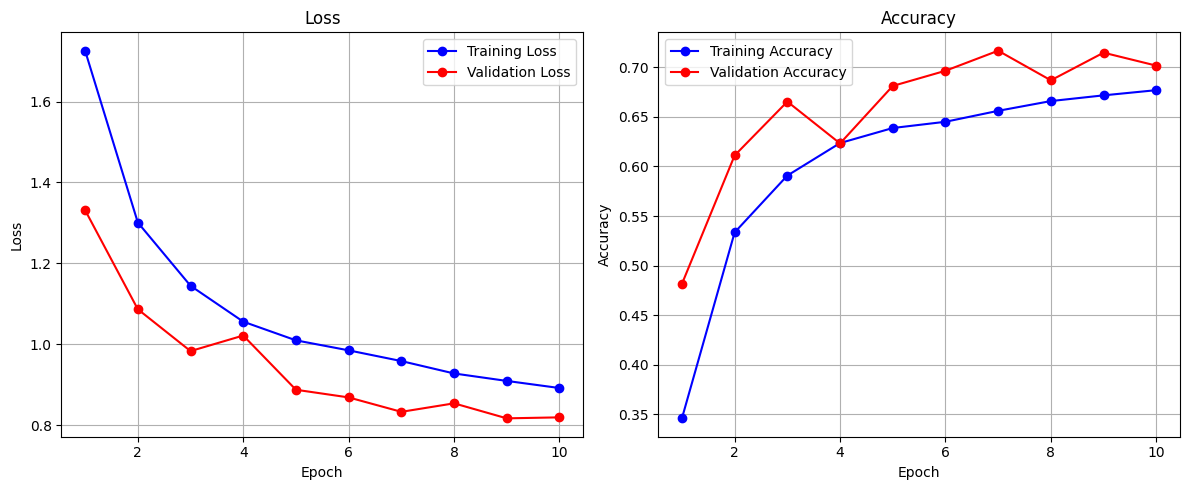

In [ ]:
# Function to plot loss and accuracy curves
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Calling the function to plot the curves
plot_loss_and_accuracy(epochs_train_losses, epochs_val_losses, epochs_train_accuracies, epochs_val_accuracies)


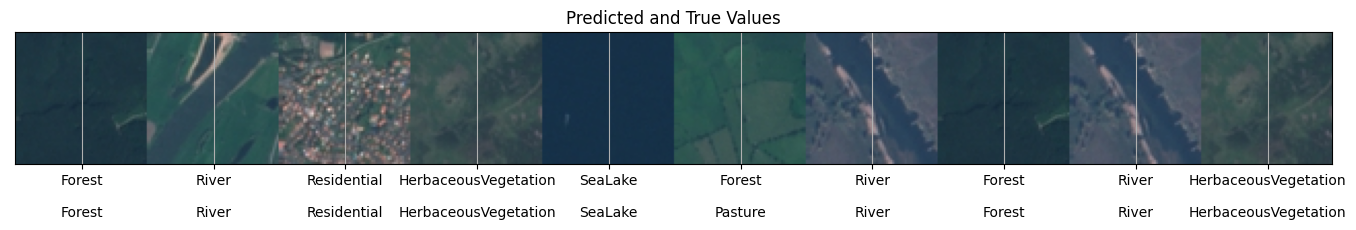

In [ ]:
# Function to display images with predictions and true labels
def display_images(images, predictions, labels, title, n):
    # Prepare the display strings containing predictions and true labels
    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    # Set up the figure for displaying the images
    plt.figure(figsize=(17, 3))
    plt.title(title)
    plt.yticks([])  # No y-axis ticks
    plt.xticks([64 * x + 32 for x in range(n)], display_strings)  # Set x-ticks with the labels
    plt.grid(None)  # Disable the grid
    
    # Reshape the images to fit the display
    image = np.reshape(images, [n, 64, 64, 3])  # Assume the images are 64x64
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [64, 64 * n, 3])
    
    # Display the images
    plt.imshow(image)

# Getting test inputs from the dataset
test_inputs = test_dataset.take(1)
x_batches, y_pred_batches, y_true_batches = [], [], []

# Collecting predictions and true labels
for x, y in test_inputs:
    y_pred = model(x)
    y_pred_batches.extend(y_pred.numpy())
    y_true_batches.extend(y.numpy())
    x_batches.extend(x.numpy())

# Select 10 random samples to display
indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = np.array(x_batches)[indexes]
y_pred_to_plot = np.array(y_pred_batches)[indexes]
y_true_to_plot = np.array(y_true_batches)[indexes]

# Convert predictions and true labels to class names
y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[np.argmax(sel_y_true)] for sel_y_true in y_true_to_plot]

# Display the images along with predicted and true labels
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)
